In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf

## Load data

In [5]:
train_df = pd.read_csv('../data/image_classification/split_train.csv')
val_df = pd.read_csv('../data/image_classification/split_val.csv')
test_df = pd.read_csv('../data/image_classification/split_test.csv')

train_df.shape, val_df.shape, test_df.shape

((21004, 21), (4501, 21), (4491, 21))

## Preprocess data

In [6]:
# Function to load images
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Resize for model input
    image = image / 255.0  # normalize
    return image

def process_labels(labels):
    return tf.convert_to_tensor(labels, dtype=tf.float32)

In [ ]:
# Convert one-hot labels to numpy array
labels_array = np.array(train_df.iloc[:, 3:].values)

class_counts = labels_array.sum(axis=0)  # Count samples per class

# Compute class weights (inverse frequency)
class_weights = {i: len(labels_array) / (len(class_counts) * class_counts[i]) for i in range(len(class_counts))}

# Function to compute sample weights based on the labels
def compute_sample_weights(labels, class_weights):
    return np.array([sum(class_weights[i] * label[i] for i in range(len(label))) for label in labels])

# Compute sample weights for each sample
sample_weights = compute_sample_weights(labels_array, class_weights)
print(sample_weights)

[2.28544193 0.84926411 1.58254858 ... 2.70125709 3.23326976 1.50955872]


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices(train_df['ImageURL']).map(load_image),
    tf.data.Dataset.from_tensor_slices(process_labels(train_df.iloc[:, 3:].values)),
    tf.data.Dataset.from_tensor_slices(sample_weights) # Add sample weights to dataset
)).batch(32).prefetch(1)

val_ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices(val_df['ImageURL']).map(load_image),
    tf.data.Dataset.from_tensor_slices(process_labels(val_df.iloc[:, 3:].values))  # Assuming labels are in columns 1 to n
)).batch(32).prefetch(1)

test_ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices(test_df['ImageURL']).map(load_image),
    tf.data.Dataset.from_tensor_slices(process_labels(test_df.iloc[:, 3:].values))  # Assuming labels are in columns 1 to n
)).batch(32).prefetch(1)

In [9]:
for img, label, _ in train_ds.take(1):
    print(img.shape, label.shape)  # Check the shape of the images and labels
    print(label)  # Check the labels

(32, 224, 224, 3) (32, 18)
tf.Tensor(
[[1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 

## Conception du CNN

### Base CNN

In [35]:
from tensorflow.keras import layers, models

# Define the minimal CNN architecture
def create_minimal_cnn(input_shape, num_classes):
    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D((2, 2)))

    # Fully connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Example usage
input_shape = (224, 224, 3)  # Example input shape for images
num_classes = len(train_df.columns[3:])  # Number of classes based on the labels
model = create_minimal_cnn(input_shape, num_classes)
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.AUC(name='AUC', multi_label=True, num_labels=len(train_df.columns[3:])),  # Adjust num_labels as needed
        'accuracy', 
        tf.keras.metrics.Precision()
    ]
)

model.summary()

c:\Users\jforc\Documents\GitHub\final_projet_lucg\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    25,690,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 18)             │         2,322 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,712,338 (98.08 MB)

 Trainable params: 25,712,146 (98.08 MB)

 Non-trainable params: 192 (768.00 B)

In [42]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True
)

model.fit(
    train_ds.map(lambda img, label, weight: (img, label, weight)),
    epochs=10, 
    validation_data=val_ds.map(lambda img, label: (img, label)),
    callbacks=[callback]
)

# Evaluate model 
print("Evaluating model...")
model.evaluate(
    test_ds.map(lambda img, label: (img, label)),
    verbose=1
)

Epoch 1/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 498s 2s/step - AUC: 0.5043 - accuracy: 0.7515 - loss: 0.5831 - precision: 0.6527 - val_AUC: 0.5001 - val_accuracy: 0.7525 - val_loss: 0.4921 - val_precision: 0.0000e+00
Epoch 2/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 502s 2s/step - AUC: 0.5015 - accuracy: 0.7557 - loss: 0.5079 - precision: 0.0000e+00 - val_AUC: 0.5001 - val_accuracy: 0.7525 - val_loss: 0.4220 - val_precision: 0.0000e+00
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 499s 2s/step - AUC: 0.5001 - accuracy: 0.7574 - loss: 0.4555 - precision: 0.0000e+00 - val_AUC: 0.5003 - val_accuracy: 0.7525 - val_loss: 0.3716 - val_precision: 0.0000e+00
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 509s 2s/step - AUC: 0.5021 - accuracy: 0.7576 - loss: 0.4194 - precision: 0.0000e+00 - val_AUC: 0.4999 - val_accuracy: 0.7525 - val_loss: 0.3349 - val_precision: 0.0000e+00
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 487s 1s/step - AUC: 0.4998 - accuracy: 0.7579 - loss: 0.3944 - precision: 0.0000e+00 - val_AUC: 0.5000 - val_acc

[0.24666307866573334, 0.5, 0.7615230679512024, 0.0]

La metrique adaptée pour ce problème est **Mean Average Precision** car :
*  Nous faisons une classification multi-label
* On a un gros desequilibre au niveau des classes

En second, on peut utiliser **F1 score** car, on a la possibilité de gérer le desequilibre des classes en utilisant le macro F1 score.

In [48]:
import matplotlib.pyplot as plt

def plot_training_history(history, model_name='Text Model', metrics=['AUC', 'loss']):
    i = 0
    fig, axes = plt.subplots(len(metrics), 1, figsize=(10, 5 * len(metrics)))
    fig.suptitle(f'{model_name} Training History', fontsize=16)
    
    for metric in metrics:
        if metric not in history.history:
            raise ValueError(f"Metric '{metric}' not found in history.")
        axes[i].plot(history.history[metric], label='Train ' + metric)
        axes[i].plot(history.history['val_' + metric], label='Val ' + metric)
        axes[i].set_title(f'{model_name} {metric}')
        axes[i].set_xlabel('Epochs')
        axes[i].set_ylabel(metric)
        axes[i].legend()
        
        i += 1
    
    plt.show()

In [49]:
def multi_label_threshold(y_pred, threshold=0.5, threshold_nb=None):
    if threshold_nb is not None:
        y_pred_top3 = np.zeros_like(y_pred, dtype=int)
        for i in range(len(y_pred)):
            top_indices = np.argsort(y_pred[i])[-threshold_nb:]
            y_pred_top3[i, top_indices] = 1
        
        return y_pred_top3
    
    return (y_pred > threshold).astype(int)

In [50]:
def mean_avg_precision(y_true, y_pred):
    precision = []
    for i in range(len(y_true)):
        true_positives = np.sum(y_true.iloc[i].values & y_pred[i])
        predicted_positives = np.sum(y_pred[i])
        if predicted_positives > 0:
            precision.append(true_positives / predicted_positives)
        else:
            precision.append(0)

    avg_precision = np.mean(precision)
    return avg_precision

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def confusion_matrice_multilabel(y_true, y_pred, labels):
    # Calculer la matrice de confusion
    conf_matrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))

    # Tracer la matrice de confusion
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for Logistic Regression Model')
    plt.show()

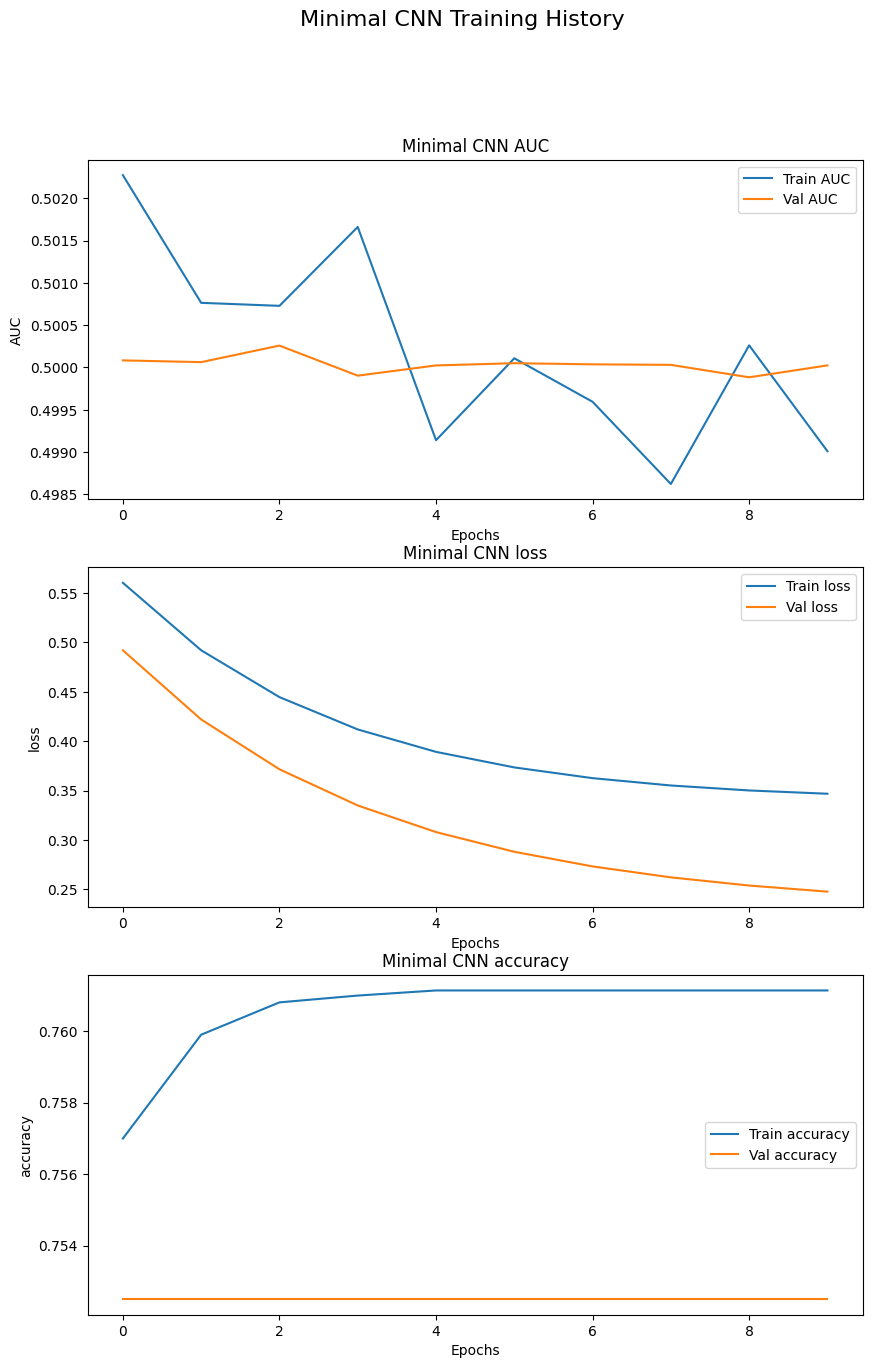

In [52]:
plot_training_history(model.history, model_name='Minimal CNN', metrics=['AUC', 'loss', 'accuracy'])

71/71 ━━━━━━━━━━━━━━━━━━━━ 16s 226ms/step
Mean Average Precision: 0.7190

Rapport de classification par classe:
              precision    recall  f1-score   support

           1       0.76      1.00      0.86      3420
           2       0.00      0.00      0.00       175
           3       0.15      1.00      0.25       655
           4       0.00      0.00      0.00       191
           5       0.00      0.00      0.00       170
           6       0.00      0.00      0.00       209
           7       0.00      0.00      0.00       183
           8       0.07      1.00      0.14       332
           9       0.00      0.00      0.00       156
          10       0.00      0.00      0.00       221
          11       0.00      0.00      0.00        90
          13       0.00      0.00      0.00        91
          14       0.00      0.00      0.00        38
          15       0.00      0.00      0.00       290
          16       0.00      0.00      0.00       165
          17       0.00

c:\Users\jforc\Documents\GitHub\final_projet_lucg\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


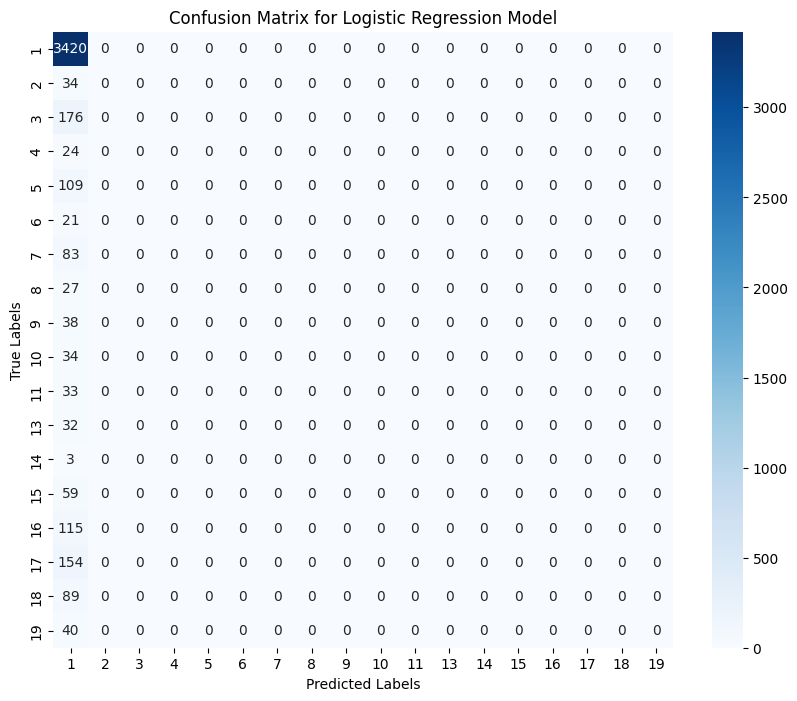

In [76]:
from sklearn.metrics import average_precision_score, classification_report


y_pred = model.predict(test_ds.map(lambda img, label: (img, label)))

y_pred_binary = multi_label_threshold(y_pred, threshold_nb=3) 

y_true = test_df.iloc[:, 3:].values  # Assuming labels are in columns 1 to n

avg_precision = average_precision_score(y_true, y_pred, average='samples')
print(f"Mean Average Precision: {avg_precision:.4f}")

print("\nRapport de classification par classe:")
print(classification_report(y_true, y_pred_binary, target_names=train_df.columns[3:]))

confusion_matrice_multilabel(y_true, y_pred_binary, labels=train_df.columns[3:])

### CNN avancées

#### ResNet

##### Expérimentation 1

In [78]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [79]:
# Implemente RESNET
base_model = ResNet50(
    weights='imagenet', 
    include_top=False, 
    input_shape=input_shape
)

for layer in base_model.layers:
    layer.trainable = False

# Ajouter les nouvelles couches de classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)  
x = Dropout(0.5)(x)  
outputs = Dense(num_classes, activation='softmax')(x) 

# creation du modele
model_resnet = Model(inputs=base_model.input, outputs=outputs)

model_resnet.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='AUC', multi_label=True, num_labels=len(train_df.columns[3:]))]
)

# Afficher le résumé du modèle
model_resnet.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 81s 1us/step


Model: "functional_44"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,646,034 (94.02 MB)

 Trainable params: 1,058,322 (4.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
model_resnet.fit(
    train_ds.map(lambda img, label, weight: (img, label, weight)),
    epochs=5,
    validation_data=val_ds.map(lambda img, label: (img, label)),
    callbacks=[callback],
    batch_size=32,
)

# Evaluate the model
print("Evaluating model...")
model_resnet.evaluate(
    test_ds.map(lambda img, label: (img, label)),
    verbose=1
)

Epoch 1/5


329/329 ━━━━━━━━━━━━━━━━━━━━ 855s 3s/step - AUC: 0.5019 - accuracy: 0.3769 - loss: 72.9095 - val_AUC: 0.5000 - val_accuracy: 0.7525 - val_loss: 110.5863
Epoch 2/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 806s 2s/step - AUC: 0.4980 - accuracy: 0.3334 - loss: 432.5609 - val_AUC: 0.4995 - val_accuracy: 0.0438 - val_loss: 164.3539
Epoch 3/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 849s 3s/step - AUC: 0.4992 - accuracy: 0.3183 - loss: 759.6186 - val_AUC: 0.5000 - val_accuracy: 0.0438 - val_loss: 227.1425
Epoch 4/5
 10/329 ━━━━━━━━━━━━━━━━━━━━ 12:03 2s/step - AUC: 0.4831 - accuracy: 0.2302 - loss: 477.1002

AbortedError: Graph execution error:

Detected at node StatefulPartitionedCall/functional_44_1/conv5_block1_0_conv_1/BiasAdd defined at (most recent call last):
<stack traces unavailable>
Operation received an exception:Status: 1, message: could not create a memory object, in file tensorflow/core/kernels/mkl/mkl_conv_ops.cc:1112
	 [[{{node StatefulPartitionedCall/functional_44_1/conv5_block1_0_conv_1/BiasAdd}}]] [Op:__inference_multi_step_on_iterator_137570]

In [ ]:
from sklearn.metrics import average_precision_score, classification_report


y_pred = model_resnet.predict(test_ds.map(lambda img, label: (img, label)))

y_pred_binary = multi_label_threshold(y_pred, threshold_nb=3) 

avg_precision = average_precision_score(y_true, y_pred, average='samples')
print(f"Mean Average Precision pour : {avg_precision:.4f}")

print("\nRapport de classification par classe:")
print(classification_report(y_true, y_pred_binary, target_names=train_df.columns[3:]))

confusion_matrice_multilabel(y_true, y_pred_binary, labels=train_df.columns[3:])

##### Expérimentation 2

In [ ]:
base_model = ResNet50(
    weights='imagenet', 
    include_top=False, 
    input_shape=input_shape
)

fine_tune_model_resnet = Model(inputs=base_model.input, outputs=outputs)

for layer in base_model.layers:
    # Dégeler uniquement les couches du dernier bloc qui sont plus specifiques a la tache a effectuer
    if 'conv5' in layer.name:  
        layer.trainable = True
    else:
        layer.trainable = False
        
# Reduire le taux d'apprentissage pour eviter de trop modifier les poids deja appris
fine_tune_model_resnet.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy', 
        tf.keras.metrics.AUC(
            name='AUC', 
            multi_label=True, 
            num_labels=len(train_df.columns[3:])
        )
    ]
)

fine_tune_model_resnet.summary()

NameError: name 'Model' is not defined

In [ ]:
fine_tune_model_resnet.fit(
    train_ds.map(lambda img, label, weight: (img, label, weight)),
    epochs=5,
    validation_data=val_ds.map(lambda img, label: (img, label)),
    callbacks=[callback],
    batch_size=32,
)

# Evaluate the model
print("Evaluating model...")
fine_tune_model_resnet.evaluate(
    test_ds.map(lambda img, label: (img, label)),
    verbose=1
)

In [ ]:
from sklearn.metrics import average_precision_score, classification_report


y_pred = fine_tune_model_resnet.predict(test_ds.map(lambda img, label: (img, label)))

y_pred_binary = multi_label_threshold(y_pred, threshold_nb=3) 

avg_precision = average_precision_score(y_true, y_pred, average='samples')
print(f"Mean Average Precision pour : {avg_precision:.4f}")

print("\nRapport de classification par classe:")
print(classification_report(y_true, y_pred_binary, target_names=train_df.columns[3:]))

confusion_matrice_multilabel(y_true, y_pred_binary, labels=train_df.columns[3:])

##### Expérimentation 3

In [ ]:
base_scratch_model_resnet = ResNet50(
    weights=None, 
    include_top=False, 
    input_shape=input_shape
)

model_scratch_resnest = Model(inputs=base_model.input, outputs=outputs)

model_scratch_resnest.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy', 
        tf.keras.metrics.AUC(
            name='AUC', 
            multi_label=True, 
            num_labels=len(train_df.columns[3:])
        )
    ]
)

model_scratch_resnest.summary()

In [ ]:
model_scratch_resnest.fit(
    train_ds.map(lambda img, label, weight: (img, label, weight)),
    epochs=5,
    validation_data=val_ds.map(lambda img, label: (img, label)),
    callbacks=[callback],
    batch_size=32,
)

# Evaluate the model
print("Evaluating model...")
model_scratch_resnest.evaluate(
    test_ds.map(lambda img, label: (img, label)),
    verbose=1
)

In [ ]:
from sklearn.metrics import average_precision_score, classification_report


y_pred = model_scratch_resnest.predict(test_ds.map(lambda img, label: (img, label)))

y_pred_binary = multi_label_threshold(y_pred, threshold_nb=3) 

avg_precision = average_precision_score(y_true, y_pred, average='samples')
print(f"Mean Average Precision pour : {avg_precision:.4f}")

print("\nRapport de classification par classe:")
print(classification_report(y_true, y_pred_binary, target_names=train_df.columns[3:]))

confusion_matrice_multilabel(y_true, y_pred_binary, labels=train_df.columns[3:])

##### Compare

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Supposons que nous avons stocké les métriques d'évaluation
metrics = {
    'Modèle': ['Resnet50', 'Fine-tune ResNet50', 'ResNet50 Scratch'],
    'Accuracy': [
        model_resnet.evaluate(val_ds.map(lambda img, label: (img, label)))[1],
        fine_tune_model_resnet.evaluate(val_ds.map(lambda img, label: (img, label)))[1],
        model_scratch_resnest.evaluate(val_ds.map(lambda img, label: (img, label)))[1]
    ],
    'AUC': [
        model_resnet.evaluate(val_ds.map(lambda img, label: (img, label)))[2],
        fine_tune_model_resnet.evaluate(val_ds.map(lambda img, label: (img, label)))[2],
        model_scratch_resnest.evaluate(val_ds.map(lambda img, label: (img, label)))[2]
    ],
}

df_metrics = pd.DataFrame(metrics)
print("Comparaison des performances:")
print(df_metrics)

# Visualisation
plt.figure(figsize=(10, 6))
plt.bar(df_metrics['Modèle'], df_metrics['Accuracy'])
plt.title('Comparaison des performances des approches VGG16')
plt.xlabel('Modèle')
plt.ylabel('Précision (Accuracy)')
plt.ylim(0, 1)
for i, v in enumerate(df_metrics['Accuracy']):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')
plt.tight_layout()
plt.show()

#### VGG16

##### Experimentation 1

In [ ]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(len(train_df.columns[3:]), activation='softmax')(x)

model_vgg_transfer = Model(inputs=base_model.input, outputs=outputs)

model_vgg_transfer.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy', 
        tf.keras.metrics.AUC(
            name='AUC', 
            multi_label=True, 
            num_labels=len(train_df.columns[3:])
        )
    ]
)

model_vgg_transfer.summary()

In [ ]:
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model_vgg_transfer.fit(
    train_ds.map(lambda img, label, weight: (img, label)),
    epochs=10,
    validation_data=val_ds.map(lambda img, label: (img, label)),
    callbacks=[callback]
)

print("Évaluation du modèle VGG16 (transfert d'apprentissage):")
model_vgg_transfer.evaluate(val_ds.map(lambda img, label: (img, label)))

In [ ]:
y_pred = model_vgg_transfer.predict(test_ds.map(lambda img, label: (img, label)))

y_pred_binary = multi_label_threshold(y_pred, threshold_nb=3) 

avg_precision = average_precision_score(y_true, y_pred, average='samples')
print(f"Mean Average Precision pour : {avg_precision:.4f}")

print("\nRapport de classification par classe:")
print(classification_report(y_true, y_pred_binary, target_names=train_df.columns[3:]))

confusion_matrice_multilabel(y_true, y_pred_binary, labels=train_df.columns[3:])

##### Experimentation 2

In [ ]:
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)

model_vgg_finetune = Model(inputs=base_model.input, outputs=outputs)

# 4. Phase 1 : Entraînement avec toutes les couches de base gelées
for layer in base_model.layers:
    if "block5" in layer.name or "block4" in layer.name:
        layer.trainable = True

model_vgg_finetune.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy', 
        tf.keras.metrics.AUC(
            name='AUC', 
            multi_label=True, 
            num_labels=len(train_df.columns[3:])
        )
    ]
)

model_vgg_finetune.summary()

In [ ]:
model_vgg_finetune.fit(
    train_ds.map(lambda img, label, weight: (img, label)),
    epochs=5,
    validation_data=val_ds.map(lambda img, label: (img, label)),
    callbacks=[callback]
)

print("Évaluation du modèle VGG16 (fine-tuning):")
model_vgg_finetune.evaluate(val_ds.map(lambda img, label: (img, label)))

In [ ]:
y_pred = model_vgg_finetune.predict(test_ds.map(lambda img, label: (img, label)))

y_pred_binary = multi_label_threshold(y_pred, threshold_nb=3) 

avg_precision = average_precision_score(y_true, y_pred, average='samples')
print(f"Mean Average Precision pour : {avg_precision:.4f}")

print("\nRapport de classification par classe:")
print(classification_report(y_true, y_pred_binary, target_names=train_df.columns[3:]))

confusion_matrice_multilabel(y_true, y_pred_binary, labels=train_df.columns[3:])

##### Experimentation 3

In [ ]:
base_scratch_model_vgg = VGG16(
    weights=None,  # Pas de poids préentraînés
    include_top=False,
    input_shape=(224, 224, 3)
)

scratch_model_vgg = Model(inputs=base_scratch_model_vgg.input, outputs=outputs)

scratch_model_vgg.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy', 
        tf.keras.metrics.AUC(
            name='AUC', 
            multi_label=True, 
            num_labels=len(train_df.columns[3:])
        )
    ]
)

scratch_model_vgg.summary()

In [ ]:
scratch_model_vgg.fit(
    train_ds.map(lambda img, label, weight: (img, label)),
    epochs=5,
    validation_data=val_ds.map(lambda img, label: (img, label)),
    callbacks=[callback]
)

print("Évaluation du modèle VGG16 (scratch):")
scratch_model_vgg.evaluate(val_ds.map(lambda img, label: (img, label)))

In [ ]:
y_pred = scratch_model_vgg.predict(test_ds.map(lambda img, label: (img, label)))
y_pred_binary = multi_label_threshold(y_pred, threshold_nb=3)

avg_precision = average_precision_score(y_true, y_pred, average='samples')
print(f"Mean Average Precision pour : {avg_precision:.4f}")

print("\nRapport de classification par classe:")
print(classification_report(y_true, y_pred_binary, target_names=train_df.columns[3:]))

confusion_matrice_multilabel(y_true, y_pred_binary, labels=train_df.columns[3:])

##### Compare

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Supposons que nous avons stocké les métriques d'évaluation
metrics = {
    'Modèle': ['VGG16 - Transfert', 'VGG16 - Fine-tuning', 'VGG16 - From Scratch'],
    'Accuracy': [
        model_vgg_transfer.evaluate(val_ds.map(lambda img, label: (img, label)))[1],
        model_vgg_finetune.evaluate(val_ds.map(lambda img, label: (img, label)))[1],
        scratch_model_vgg.evaluate(val_ds.map(lambda img, label: (img, label)))[1]
    ], 
    'AUC': [
        model_vgg_transfer.evaluate(val_ds.map(lambda img, label: (img, label)))[2],
        model_vgg_finetune.evaluate(val_ds.map(lambda img, label: (img, label)))[2],
        scratch_model_vgg.evaluate(val_ds.map(lambda img, label: (img, label)))[2]
    ],
}

df_metrics = pd.DataFrame(metrics)
print("Comparaison des performances:")
print(df_metrics)

# Visualisation
plt.figure(figsize=(10, 6))
plt.bar(df_metrics['Modèle'], df_metrics['Accuracy'])
plt.title('Comparaison des performances des approches VGG16')
plt.xlabel('Modèle')
plt.ylabel('Précision (Accuracy)')
plt.ylim(0, 1)
for i, v in enumerate(df_metrics['Accuracy']):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')
plt.tight_layout()
plt.show()

## Analyse des résultats

### Quelques exemples

In [ ]:
# Visualize a few predictions from the image model
batch = next(iter(test_ds))

_, images_batch,labels_batch = batch
preds_img = image_model.predict(images_batch)
plt.figure(figsize=(10, 10))

for i in range(min(9, images_batch.shape[0])):
    true_labels = train_df.iloc[:, 3:].columns[labels_batch[i] == 1]
    print(f"True:{true_labels}")
    predicted_labels = train_df.iloc[:, 3:].columns[preds_img[i] > 0.4]
    print(f"Pred:{predicted_labels}")
    print(f"Pred: {np.around(preds_img[i], 1)}\nTrue: {labels_batch[i]}")
    plt.subplot(3, 3, i + 1)
    plt.imshow(images_batch[i])
    plt.title(f"Pred: {predicted_labels}\nTrue: {true_labels}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### Explicability avec LIME

In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np

# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Select an image from the test dataset
for img, label in test_ds.take(1):
    img = img[0].numpy()  # Take the first image in the batch
    label = label[0].numpy()  # Corresponding label

# Define a prediction function for LIME
def predict_fn(images):
    return model.predict(images)

# Explain the prediction for the selected image
explanation = explainer.explain_instance(
    img.astype('double'),
    predict_fn,
    top_labels=3,
    hide_color=0,
    num_samples=1000
)

# Visualize the explanation
temp, mask = explanation.get_image_and_mask(
    label=np.argmax(label),  # Use the true label or predicted label
    positive_only=True,
    num_features=5,
    hide_rest=False
)

# Display the image with explanations
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title("LIME Explanation")
plt.axis('off')
plt.show()

In [ ]:
# Examine prediction errors
for img, label in test_ds.take(1):
    preds = model.predict(img)
    preds_binary = multi_label_threshold(preds, threshold_nb=3)
    true_labels = label.numpy()

    # Identify misclassified examples
    for i in range(len(true_labels)):
        if not np.array_equal(true_labels[i], preds_binary[i]):
            print(f"Example {i}:")
            print(f"True Labels: {train_df.columns[3:][true_labels[i] == 1]}")
            print(f"Predicted Labels: {train_df.columns[3:][preds_binary[i] == 1]}")
            plt.imshow(img[i].numpy())
            plt.title(f"Misclassified Example {i}")
            plt.axis('off')
            plt.show()